## Learning Models

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2)
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout()
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2)
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout()
    return axes

# Table of Contents
* [Learning a model](#Learning-a-model)
	* [The process of learning](#The-process-of-learning)
		* [A real simple model](#A-real-simple-model)
		* [The Hypothesis or Model Space](#The-Hypothesis-or-Model-Space)
		* [Deterministic Error or Bias](#Deterministic-Error-or-Bias)
		* [How to learn the best fit model in a hypothesis space](#How-to-learn-the-best-fit-model-in-a-hypothesis-space)
	* [The Structure of Learning](#The-Structure-of-Learning)
		* [Empirical Risk Minimization](#Empirical-Risk-Minimization)
		* [The role of sampling](#The-role-of-sampling)
		* [Statement of the learning problem.](#Statement-of-the-learning-problem.)
	* [Noise](#Noise)
		* [Stochastic Noise, or the problem with randomness.](#Stochastic-Noise,-or-the-problem-with-randomness.)
		* [Systematic error](#Systematic-error)
	* [Fitting a noisy model: the complexity of your hypothesis](#Fitting-a-noisy-model:-the-complexity-of-your-hypothesis)
		* [The Variance of your model](#The-Variance-of-your-model)
	* [Testing and Training Sets](#Testing-and-Training-Sets)
		* [A short digression about scikit-learn](#A-short-digression-about-scikit-learn)
		* [How do training and testing error change with complexity?](#How-do-training-and-testing-error-change-with-complexity?)
			* [The structure of `scikit-learn`](#The-structure-of-scikit-learn)
	* [Validation](#Validation)
	* [Cross Validation](#Cross-Validation)
		* [The Idea](#The-Idea)
		* [The entire description of K-fold Cross-validation](#The-entire-description-of-K-fold-Cross-validation)
	* [Regularization](#Regularization)
		* [Regularization of the Romney model with Cross-Validation](#Regularization-of-the-Romney-model-with-Cross-Validation)
		* [What is minimized where?](#What-is-minimized-where?)

Do you remember the Predictwise probabilities question from two labs back? We learnt how to simulate from the predictwise probabilities.

## The process of learning
But how did we get those probabilities in the first place? To do that, we need to focus on **learning a model** for those probabilities.

Here we encounter some challenges that occur in learning such a model from data. These challenges are small samples of data and noise in the data, as well as issues related to the complexity of the models we use, such as bias, and variance or overfitting. We'll encounter hypothesis spaces, and the basic idea of error or risk minimization that is used to learn models. We'll also see the critical and multifarious role that sampling plays in the learning process.

Lets say we are trying to predict is a human process such as an election. Here economic and sociological factors are important, such as poverty, race and religiousness. There are historical correlations between such factors and election outcomes which we might want to incorporate into our model. An example of such a model might be:

*The odds of Romney winning are a function of population religiosity, race, poverty, education, and other social and economic indicators. *

Our **causal** argument motivating this model here might be that religious people are more socially conservative and thus more likely to vote republican. This might not be the correct causation, but thats not entirely important for the prediction. As long as a **correlation** exists, our model is more structured than 50-50 randomness, and we can try and make a prediction. Remember of-course, our model may even be wrong (see Box's aphorism: https://en.wikipedia.org/wiki/All_models_are_wrong).

We'll represent the variable being predicted, such as the probability of voting for Romney, by the letter $y$, and the **features** or **co-variates** we use as an input in this probability by the letter $x$. This $x$ could be multi-dimensional, with $x_1$ being poverty, $x_2$ being race, and so on.

We then write 

$$ y = f(x) $$

and our jobs is to take $x$ such as data from the census about race, religiousness, and so on, and $y$ as previous elections and the results of polls that pollsters come up with, and to make a predictive model for the elections. That is, we wish to estimate $f(x)$.

The more domain knowledge we can bring to bear on this problem, the better. The work of folks like Nate Silver isn't just the statistical analysis. They combine their statistical expertise with modelling choices about causal and correlational effects based on their domain knowledge. Sometimes they are right and sometimes wrong.

### A real simple model
To gently step feet in the modelling world, lets see consider very simple model, where the probability of voting for Romney is a function only of how religious the population in a county is.

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

Let us assume that we have a "population" of 200 counties $x$:

In [4]:
df = pd.read_csv("./Resources/Data/religion.csv") # Note that data was cooked up for this example
df.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


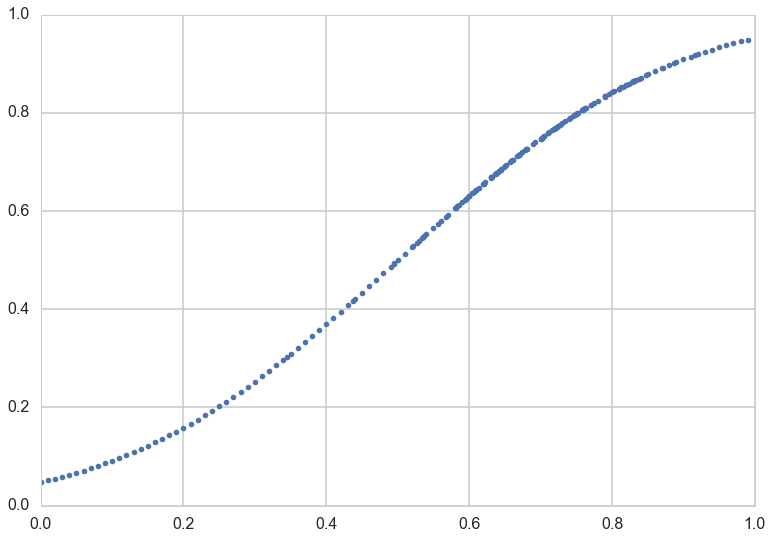

In [13]:
x = df.rfrac.values
f = df.promney.values
plt.plot(x, f, '.')

Notice that our sampling of $x$ is not quite uniform: there are more points around $x$ of 0.7. Also, looks like logistic function.

Now, in real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

In [14]:
# Get 30 in-sample data randomly from population
indices = np.sort(np.random.choice(x.shape[0], size=30, replace=False))

samplex = x[indices]
samplef = f[indices]

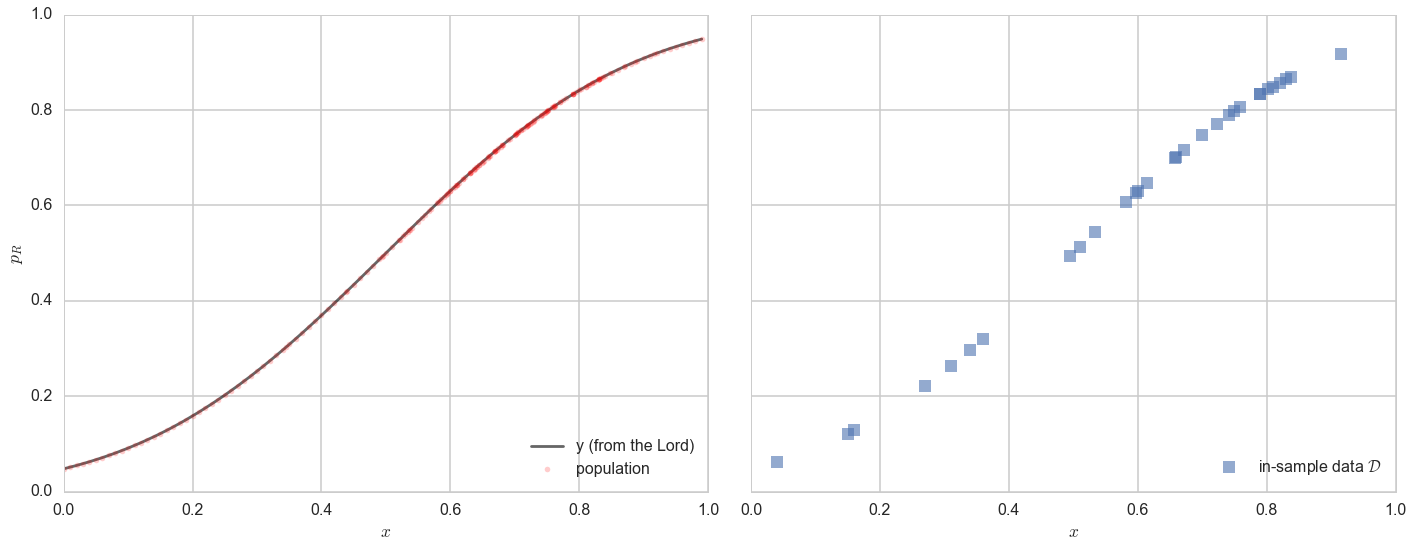

In [15]:
# Plot
axes = make_plot()
axes[0].plot(x,f, 'k-', alpha=0.6, label="y (from the Lord)")
axes[0].plot(x,f, 'r.', alpha=0.2, label="population")
axes[1].plot(samplex,samplef, 's', alpha=0.6, label="in-sample data $\cal{D}$")
axes[0].legend(loc=4)
axes[1].legend(loc=4)

The lightly shaded squares in the right panel plot are the in-sample $\cal{D}$ of 30 points given to us. Let us then pretend that we have forgotten the curve that the Lord gave us. Thus, all we know is what is on the plot on the right, and we have no clue about what the original curve was, nor do we remember the original "population".

That is, imagine the Lord gave us $f$ but then also gave us amnesia. Remember that such amnesia is the general case in learning, where we *do not know* the target function, but rather just have some data. Thus what we will be doing is *trying to find functions that might have generated the 30 points of data that we can see* in the hope that one of these functions might approximate $f$ well, and provide us a **predictive model** for future data. This is known as **fitting** the data.

### The Hypothesis or Model Space
Such a function, one that we use to fit the data, is called a **hypothesis**. We'll use the notation $h$ to denote a hypothesis. Lets consider as hypotheses for the data above, a particular class of functions called polynomials. 

A polynomial is a function that combines multiple powers of x linearly.

\begin{align*}
h(x) &=& 9x - 7 && \,(straight\, line) \\
h(x) &=& 4x^2 + 3x + 2 && \,(quadratic) \\
h(x) &=& 5x^3 - 31x^2 + 3x  && \,(cubic).
\end{align*}

In general, a polynomial can be written thus:

\begin{eqnarray*}
 h(x) &=& a_0 + a_1 x^1 + a_2 x^2 + ... + a_n x^n \\
      &=& \sum_{i=0}^{n} a_i x^i
\end{eqnarray*}

Thus, by linearly we mean a sum of coefficients $a_i$ times powers of $x$, $x^i$. In other words, the polynomial is **linear in its coefficients**.

Let us consider as the function we used to fit the data, a hypothesis $h$ that is a straight line. We put the subscript $1$ on the $h$ to indicate that we are fitting the data with a polynomial of order 1, or a straight line. This looks like:

$$ h_1(x) = a_0 + a_1 x $$

We'll call the **best fit** straight line the function $g_1(x)$. The "best fit" idea is this: amongst the set of all lines (i.e., all possible choices of $h_1(x)$), what is the best line $g_1(x)$ that represents the in-sample data we have? (The subscript $1$ on $g$ is chosen to indicate the best fit polynomial of degree 1, ie the line amongst lines that fits the data best).

The best fit $g_1(x)$ is calculated and shown in the figure below:

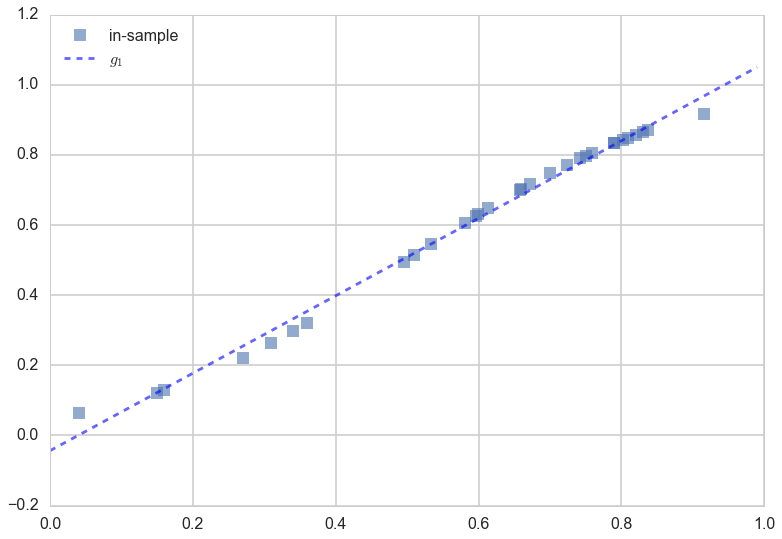

In [24]:
# Numpy has functions to find best fit 
g1 = np.poly1d(np.polyfit(samplex, samplef, 1)) # g1(x) -> 1d best fit prediction

plt.plot(samplex, samplef, 's', alpha=0.6, label="in-sample")
plt.plot(x,g1(x), 'b--', alpha=0.6, label="$g_1$")
plt.legend(loc=0)

How did we calculate the best fit? We'll come to that in a bit, but in the meanwhile, lets formalize and generalize the notion of "best fit line amongst lines" a bit.

The set of all functions of a particular kind that we could have used to fit the data is called a **Hypothesis Space**. The words "particular kind" are deliberately vague: its our choice as to what we might want to put into a hypothesis space. A hypothesis space is denoted by the notation $\cal{H}$.

Lets consider the hypothesis space of all straight lines $h_1(x)$. We'll denote it as $\cal{H}_1$, with the subscript being used to mark the order of the polynomial. Another such space might be $\cal{H}_2$, the hypothesis space of all quadratic functions. A third such space might combine both of these together. We get to choose what we want to put into our hypothesis space.

In this set-up, what we have done in the code and plot above is this: we have found the best $g_1$ to the data $\cal{D}$ from the functions in the hypothesis space $\cal{H}_1$. This is not the best fit from all possible functions, but rather, the best fit from the set of all the straight lines. 

The hypothesis space is a concept we use to capture the **complexity** of a model you use to fit data. For example, since quadratics are more complex functions than straight lines (they curve more), $\cal{H}_2$ is more complex than $\cal{H}_1$. 

In this case, suffering from amnesia about the real model, we decided to use the simplest hypothesis space that gives us some indication of the *trend* of our data: the set of straight lines.

### Deterministic Error or Bias
Notice from the figure above that models in $\cal{H}_1$, i.e., straight lines, and the best-fit straight line $g_1$ in particular, do not do a very good job of capturing the curve of  the data (and thus the underlying function $f$ that we are trying to approximate. Consider the more general case in the figure below, where a curvy $f$ is approximated by a function $g$ which just does not have the wiggling that $f$ has. 

![m:Bias](./Resources/images/bias.png)

There is always going to be an error then, in approximating $f$ by $g$. This *approximation error* is shown in the figure by the blue shaded region, and its called **bias**, or **deterministic error**. The former name comes from the fact that $g$ just does not wiggle the way $f$ does (nothing will make a straight line curve). The latter name (which I first saw used in http://www.amlbook.com/ ) comes from the notion that if you did not know the target function $f$, which is the case in most learning situations, you would have a hard time distinguishing this error from any other errors such as measurement and noise...

Going back to our model at hand, it is clear that the space of straight lines $\cal{H}_1$ does not capture the curving in the data. So let us consider the more complex hypothesis space $\cal{H}_{20}$, the set of all 20th order polynomials $h_{20}(x)$:

$$h_{20}(x) = \sum_{i=0}^{20} a_i x^i\,.$$
To see how a more complex hypothesis space does, lets find the best fit 20th order polynomial $g_{20}(x)$.

/Users/Sachin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app


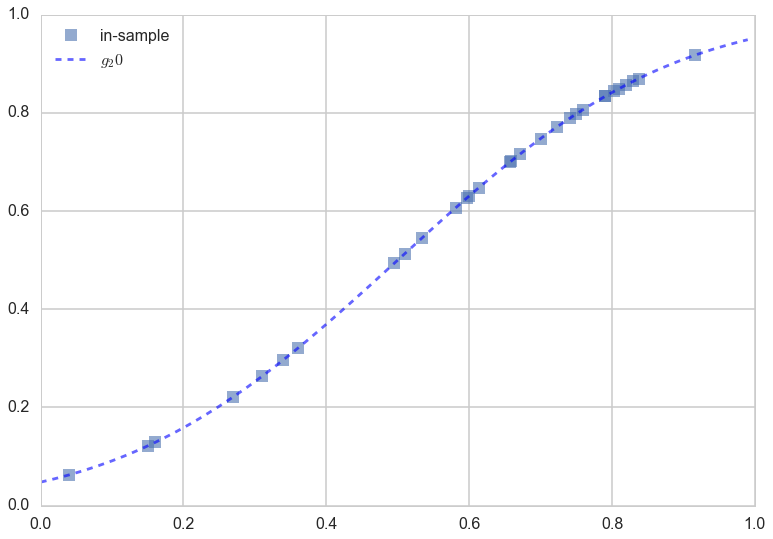

In [28]:
# Numpy has functions to find best fit 
g20 = np.poly1d(np.polyfit(samplex, samplef, 20)) # g1(x) -> dim=20 best fit prediction

plt.plot(samplex, samplef, 's', alpha=0.6, label="in-sample")
plt.plot(x,g20(x), 'b--', alpha=0.6, label="$g_20$")
plt.legend(loc=0)

Voila! You can see the 20th order polynomial does a much better job of tracking the points, because of the wiggle room it has in making a curve "go near or through" all the points as opposed to a straight line, which well, cant curve. Thus it would seem that $\cal{H}_{10}$ might be a better candidate hypothesis set from which to choose a best fit model. 

We can quantify this by calculating some notion of the bias for both $g_1$ and $g_{20}$. 
To do this we calculate the square of the difference between f and the g's on the population of 200 points i.e.:

$$B_1(x) = (g_1(x) - f(x))^2 \,;\,\, B_{20}(x) = (g_{20}(x) - f(x))^2\,.$$ 

Squaring makes sure that we are calculating a positive quantity.

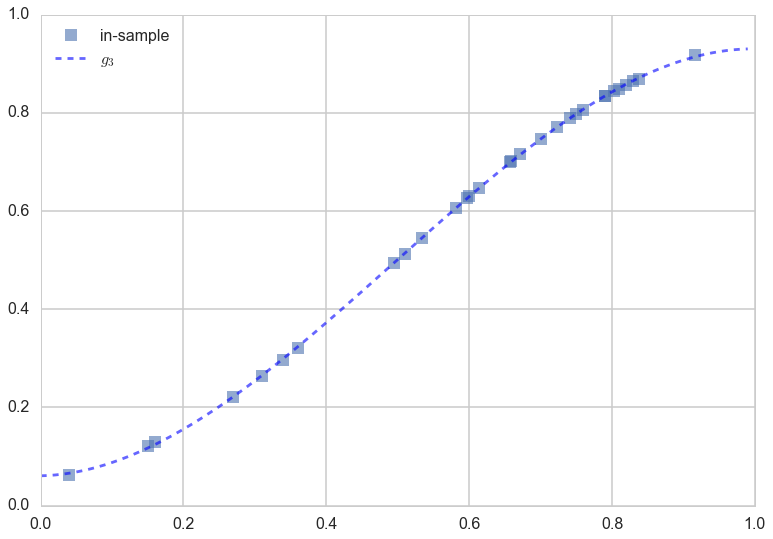

In [35]:
# A dim=3 polynomial may also capture this fit
g3 = np.poly1d(np.polyfit(samplex, samplef, 3)) # g1(x) -> dim=20 best fit prediction

plt.plot(samplex, samplef, 's', alpha=0.6, label="in-sample")
plt.plot(x,g3(x), 'b--', alpha=0.6, label="$g_3$")
plt.legend(loc=0)

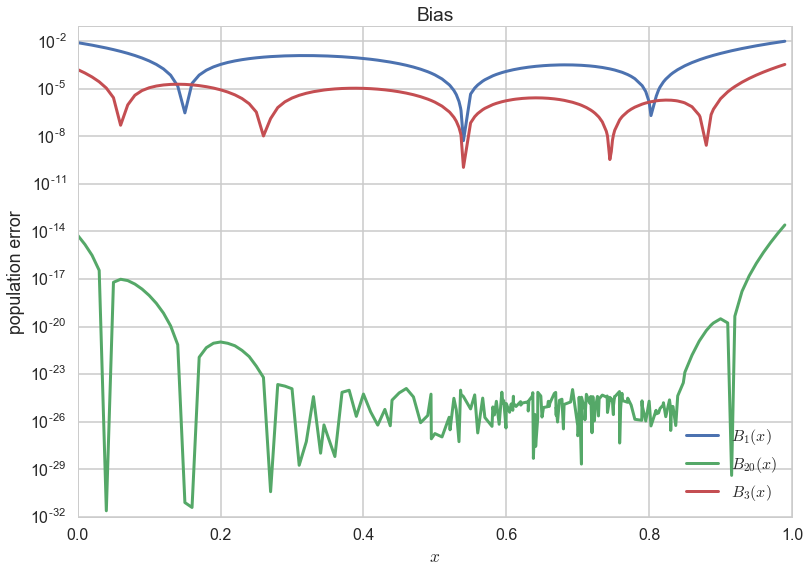

In [37]:
plt.plot(x, (g1(x)-f)**2, lw=3, label="$B_1(x)$")
plt.plot(x, (g20(x)-f)**2, lw=3,label="$B_{20}(x)$")
plt.plot(x, (g3(x)-f)**2, lw=3,label="$B_{3}(x)$")
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4)
plt.title("Bias")

As you can see the **bias or approximation error** is much smaller for $g_{20}$.

Is $g_{20}$ the best model for this data from all possible models? Indeed, how do we find the best fit model from the best hypothesis space? This is what **learning** is all about.

We have used the python function `np.polyfit` to find $g_{1}$ the best fit model in $\cal{H}_{1}$ and $g_{20}$ the best fit model in $\cal{H}_{20}$, but how did we arrive at that conclusion? This is the subject of the next section. 